# Heart Attack Dataset - Exploratory Data Analysis
- Dataset path: `data/heart_attack_base.csv`


### Import and Theme Setting

In [94]:
# Imports and settings
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

DATA_PATH = '../../data/phase4_post_pca_ca-thal-included.csv'
TARGET_COL = 'target'

def detect_column_types(df: pd.DataFrame, target_col: str | None = None, cat_max_unique: int = 10):
    cont_cols = []
    cat_cols = []
    for col in df.columns:
        if col == target_col:
            continue
        if pd.api.types.is_numeric_dtype(df[col]):
            # if numeric but low unique count -> treat as categorical variable
            if df[col].nunique(dropna=True) <= cat_max_unique:
                cat_cols.append(col)
            else:
                cont_cols.append(col)
        else:
            cat_cols.append(col)
    return cont_cols, cat_cols

### Dataset Overview


In [95]:
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

print(f"Shape: {df.shape}")
df.head()

Shape: (2919, 14)


,ThalCA_PC1,ThalCA_PC2,age,chol,cp,exang,fbs,oldpeak,restecg,sex,slope,thalach,trestbps,target
0,1.839461,5.682082,63.0,233.0,4,0,1,0.926887,0,1,1,150.0,145.0,1
1,-0.836875,-0.033552,37.0,250.0,3,0,0,1.085912,1,1,1,187.0,130.0,1
2,-0.836875,-0.033552,41.0,204.0,2,0,0,0.725488,0,0,3,172.0,130.0,1
3,-0.836875,-0.033552,56.0,236.0,2,0,0,0.517400,1,1,3,178.0,120.0,1
4,-0.836875,-0.033552,57.0,330.0,1,1,0,0.424239,1,0,3,163.0,120.0,1


### Missing Value and Duplicated Check


In [96]:
# Missing values and duplicates overview
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_percentages = (missing_counts / len(df) * 100).round(2)
missing_table = pd.DataFrame({'missing_count': missing_counts, 'missing_percentage': missing_percentages})

print("=== Table of Missing Values per Column ===")
if missing_table['missing_count'].sum() > 0:
    display(missing_table[missing_table['missing_count'] > 0])
else:
    print("No missing values found.\n")


# Print all duplicated rows (all copies)
num_duplicates = df.duplicated().sum()
print("=== Duplicate Rows ===")
print(f"Duplicate rows: {num_duplicates}")

dupes_all = df[df.duplicated(keep=False)]
if dupes_all.shape[0] > 0:
    display(dupes_all)


=== Table of Missing Values per Column ===
No missing values found.

=== Duplicate Rows ===
Duplicate rows: 1414


,ThalCA_PC1,ThalCA_PC2,age,chol,cp,exang,fbs,oldpeak,restecg,sex,slope,thalach,trestbps,target
4,-0.836875,-0.033552,57.0,330.0,1,1,0,0.424239,1,0,3,163.0,120.0,1
5,1.839461,5.682082,57.0,192.0,1,0,0,0.312564,1,1,2,148.0,140.0,1
6,-0.836875,-0.033552,56.0,294.0,2,0,0,0.696352,0,0,2,153.0,140.0,1
7,2.306455,-0.863338,44.0,263.0,2,0,0,-0.000000,1,1,3,173.0,120.0,1
8,2.306455,-0.863338,52.0,199.0,3,0,1,0.371090,1,1,3,162.0,160.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-0.836875,-0.033552,59.0,221.0,2,1,0,-0.000000,1,1,3,164.0,140.0,1
2915,2.856927,-0.811738,60.0,258.0,1,1,0,1.007408,0,1,2,141.0,125.0,0
2916,-0.286402,0.018049,47.0,275.0,1,1,0,0.596708,0,1,2,118.0,110.0,0
2917,-0.836875,-0.033552,50.0,254.0,1,0,0,-0.000000,0,0,3,159.0,110.0,1


### Column Types Detection


In [97]:
print("Columns:", list(df.columns))

continuous_cols, categorical_cols = detect_column_types(df, target_col=TARGET_COL)

# Exclude target column 
if TARGET_COL in categorical_cols:
    categorical_cols = [c for c in categorical_cols if c != TARGET_COL]

# In Kaggle dataset, there are 'ca' column which is categorical but treated as numeric
if 'ca' in categorical_cols:
    categorical_cols.remove('ca')
    continuous_cols.append('ca')

print("\nContinuous columns:", continuous_cols)
print("Categorical columns:", categorical_cols)

df.dtypes

Columns: ['ThalCA_PC1', 'ThalCA_PC2', 'age', 'chol', 'cp', 'exang', 'fbs', 'oldpeak', 'restecg', 'sex', 'slope', 'thalach', 'trestbps', 'target']

Continuous columns: ['ThalCA_PC1', 'ThalCA_PC2', 'age', 'chol', 'oldpeak', 'thalach', 'trestbps']
Categorical columns: ['cp', 'exang', 'fbs', 'restecg', 'sex', 'slope']


ThalCA_PC1    float64
ThalCA_PC2    float64
age           float64
chol          float64
cp              int64
exang           int64
fbs             int64
oldpeak       float64
restecg         int64
sex             int64
slope           int64
thalach       float64
trestbps      float64
target          int64
dtype: object

### Descriptive Statistics for Continuous Variables


In [98]:
# Descriptive statistics for continuous variables
if len(continuous_cols) == 0:
    print("No continuous columns detected.")
else:
    desc = df[continuous_cols].describe().T
    # add additional stats
    desc['median'] = df[continuous_cols].median()
    desc['std'] = df[continuous_cols].std()
    desc = desc.rename(columns={'25%': 'q1', '50%': 'q2', '75%': 'q3'})
    display(desc[['count', 'mean', 'median', 'std', 'min', 'q1', 'q2', 'q3', 'max']])


,count,mean,median,std,min,q1,q2,q3,max
ThalCA_PC1,2919.0,1.207363e-15,-0.836875,1.492492,-0.836875,-0.836875,-0.836875,-0.286402,4.508345
ThalCA_PC2,2919.0,-4.259849e-16,-0.033552,1.026072,-0.863338,-0.033552,-0.033552,-0.033552,5.836884
age,2919.0,5.403015e+01,55.000000,9.203907,28.000000,47.000000,55.000000,61.000000,77.000000
chol,2919.0,2.440281e+02,240.000000,45.781021,141.000000,211.000000,240.000000,276.000000,330.000000
oldpeak,2919.0,4.455544e-01,0.517400,0.393075,-0.000000,-0.000000,0.517400,0.778817,1.085912
thalach,2919.0,1.471384e+02,150.000000,23.476120,90.000000,130.000000,150.000000,164.000000,202.000000
trestbps,2919.0,1.311689e+02,130.000000,15.535161,100.000000,120.000000,130.000000,140.000000,160.000000


### Histograms and KDE for Continuous Variables
- **What:** Shows the distribution of each continuous feature with histograms and KDEs
- **Why:** Understand distributional shape also helps interpret boxplot outliers and later model residuals

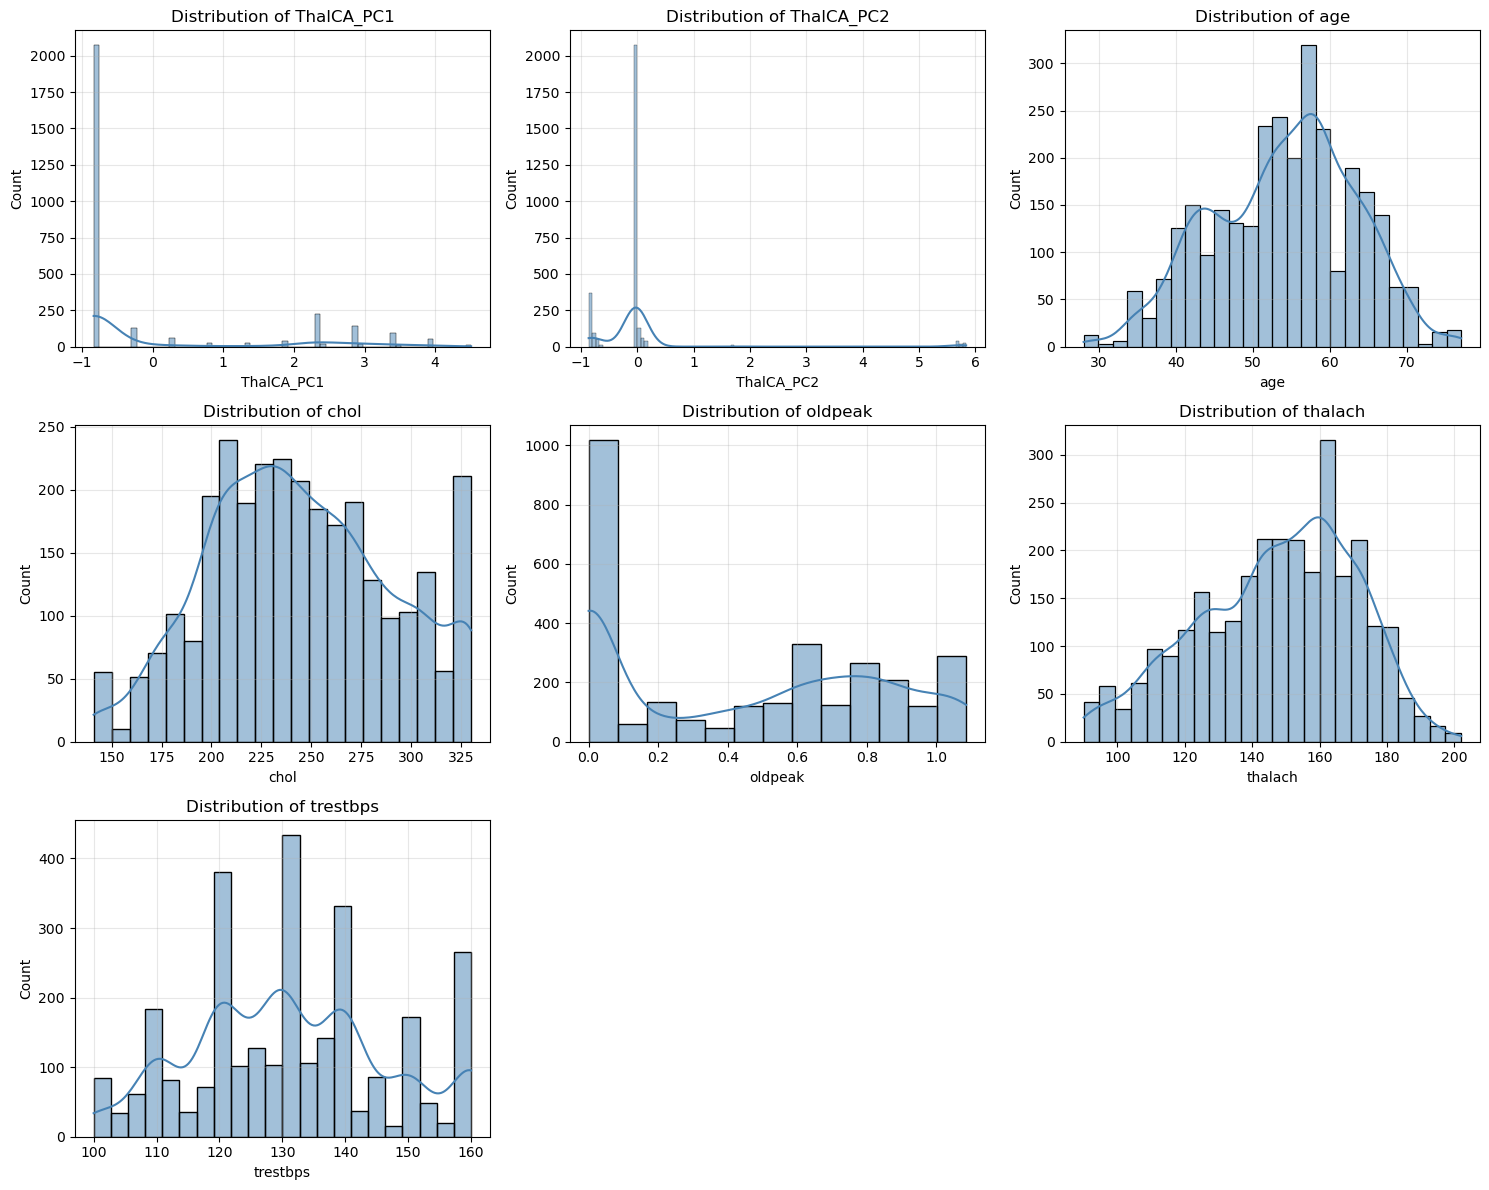

In [99]:
# Histograms and KDE for continuous variables
if len(continuous_cols) == 0:
    print("No continuous columns to plot.")
else:
    n = len(continuous_cols)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(continuous_cols):
        ax = axes[i]
        sns.histplot(data=df, x=col, ax=ax, stat="count", color="steelblue", edgecolor="black", kde=True)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.grid(True, alpha=0.3)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


### Frequency Tables for Categorical Variables


In [100]:
# Frequency tables for categorical variables
if len(categorical_cols) == 0:
    print("No categorical columns detected.")
else:
    for col in categorical_cols + ([TARGET_COL] if TARGET_COL in df.columns else []):
        print(f"\n=== {col} ===")
        _vc = df[col].value_counts(dropna=False).sort_index()
        _table_df = _vc.rename_axis(col).reset_index(name='count')
        _table_df['percent'] = (_table_df['count'] / _table_df['count'].sum() * 100).round(2)
        _table = _table_df.style.hide(axis='index').format({'percent': '{:.2f}%'})
        display(_table)



=== cp ===


cp,count,percent
1,771,26.41%
2,554,18.98%
3,866,29.67%
4,728,24.94%



=== exang ===


exang,count,percent
0,1910,65.43%
1,1009,34.57%



=== fbs ===


fbs,count,percent
0,2471,84.65%
1,448,15.35%



=== restecg ===


restecg,count,percent
0,1503,51.49%
1,799,27.37%
2,617,21.14%



=== sex ===


sex,count,percent
0,862,29.53%
1,2057,70.47%



=== slope ===


slope,count,percent
1,845,28.95%
2,1384,47.41%
3,690,23.64%



=== target ===


target,count,percent
0,1342,45.97%
1,1577,54.03%


### Bar Charts for Categorical Variables


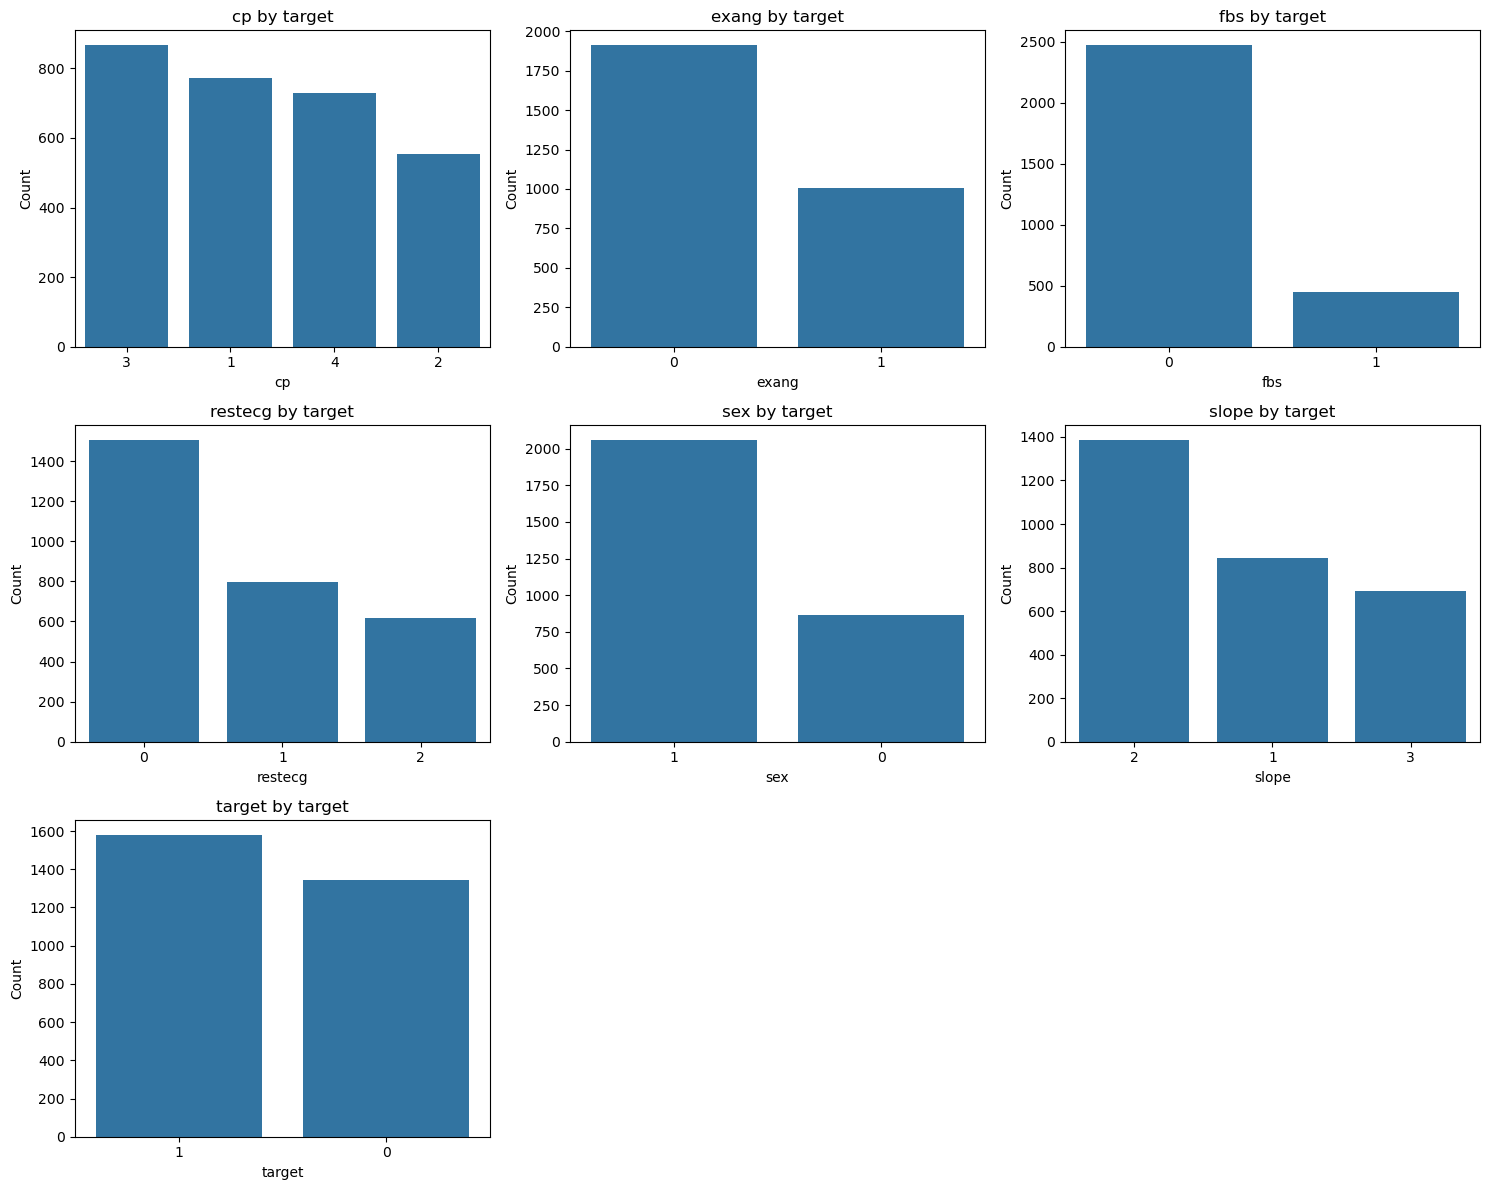

In [101]:
# Bar charts for categorical variables
if len(categorical_cols) == 0:
    print("No categorical columns to plot.")
else:
    cat_to_plot = categorical_cols + [TARGET_COL]
    
    n = len(cat_to_plot)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(cat_to_plot):
        ax = axes[i]
        order = df[col].value_counts().index  # order by frequency
        sns.countplot(data=df, x=col, order=order, ax=ax)
        ax.set_title(f"{col} by {TARGET_COL}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.grid(False)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Data Quality Summary
- **Result on Quality**:
  - `CLEAN_ENOUGH`: Proceed to modeling; keep monitoring during validation.
  - `MOSTLY_CLEAN_WITH_OUTLIERS`: Consider capping/winsorizing or robust scalers; tree-based models are less sensitive.
  - `NEEDS_ATTENTION`: Address missing/duplicates/implausible ranges before modeling.


In [102]:
summary = {}

# Missing and duplicates
missing_counts = df.isna().sum()
summary['missing_total'] = int(missing_counts.sum())
summary['missing_columns'] = {c: int(missing_counts[c]) for c in df.columns if missing_counts[c] > 0}
summary['duplicates'] = int(df.duplicated().sum())

# Type detection
continuous_cols, categorical_cols = detect_column_types(df, target_col=TARGET_COL)
summary['continuous_cols'] = continuous_cols
summary['categorical_cols'] = categorical_cols

# Plausibility checks
plausible_flags = []
if 'age' in df.columns:
    plausible_flags.append(df['age'].between(18, 100, inclusive='both').all())
if 'trestbps' in df.columns:
    plausible_flags.append((df['trestbps'] > 0).all())
if 'cholesterol' in df.columns:
    plausible_flags.append((df['cholesterol'] > 0).all())
if 'max heart rate' in df.columns:
    plausible_flags.append((df['max heart rate'] > 0).all())
summary['plausible_ranges_pass'] = all(plausible_flags) if plausible_flags else None

# Outlier rate
outlier_rates = {}
for col in continuous_cols:
    s = df[col].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    rate = float(((s < lower) | (s > upper)).mean())
    outlier_rates[col] = round(rate, 4)
summary['outlier_rates'] = outlier_rates

# Target balance
if TARGET_COL in df.columns:
    vc = df[TARGET_COL].value_counts(normalize=True)
    summary['target_balance'] = {int(k): round(float(v), 4) for k, v in vc.items()}

# Overall verdict
def verdict_from_summary(s):
    if s['missing_total'] == 0 and s['duplicates'] == 0 and (s['plausible_ranges_pass'] in [True, None]):
        # outliers allowed if low or clinically plausible
        hi_outliers = [c for c, r in s['outlier_rates'].items() if r > 0.1]
        if len(hi_outliers) == 0:
            return 'CLEAN_ENOUGH'
        return 'CONTAINING_[OUTLIERS = {s["outlier_rates"]}]'
    return f'CONTAINING_[MISSING = {s["missing_total"]} | DUPLICATES = {s["duplicates"]} | PLAUSIBLE_RANGES_PASS = {s["plausible_ranges_pass"]}]'
summary['verdict'] = verdict_from_summary(summary)

print('Data Quality Summary:')
for k, v in summary.items():
    print(f"- {k}: {v}")

Data Quality Summary:
- missing_total: 0
- missing_columns: {}
- duplicates: 1414
- continuous_cols: ['ThalCA_PC1', 'ThalCA_PC2', 'age', 'chol', 'oldpeak', 'thalach', 'trestbps']
- categorical_cols: ['cp', 'exang', 'fbs', 'restecg', 'sex', 'slope']
- plausible_ranges_pass: True
- outlier_rates: {'ThalCA_PC1': 0.2258, 'ThalCA_PC2': 0.2915, 'age': 0.0, 'chol': 0.0, 'oldpeak': 0.0, 'thalach': 0.0, 'trestbps': 0.0}
- target_balance: {1: 0.5403, 0: 0.4597}
- verdict: CONTAINING_[MISSING = 0 | DUPLICATES = 1414 | PLAUSIBLE_RANGES_PASS = True]


#### Detect and Display Plausibility Violations

In [103]:
# # check plausibility violations
# viol_masks = {
#   "age_out_of_range": ~df["age"].between(18, 100, inclusive="both"),
#   "trestbps_nonpositive": df["trestbps"] <= 0,
#   "cholesterol_nonpositive": df["cholesterol"] <= 0,
#   "oldpeak_negative": df["oldpeak"] < 0,
#   "max_hr_nonpositive": df["max heart rate"] <= 0,
# }

# counts = {k: int(m.sum()) for k, m in viol_masks.items()}
# print(counts)

# def show_examples(mask, cols, n=10):
#   subset = df.loc[mask, cols].copy()
#   subset.insert(0, "csv_line", subset.index + 2)
#   return subset.head(n)

# cols = ["age", "trestbps", "cholesterol", "oldpeak", "max heart rate"]

# if viol_masks["trestbps_nonpositive"].sum() > 0:
#     print("\n=== trestbps_nonpositive ===")
#     display(show_examples(viol_masks["trestbps_nonpositive"], cols))

# if viol_masks["cholesterol_nonpositive"].sum() > 0:
#     print("\n=== cholesterol_nonpositive ===")
#     display(show_examples(viol_masks["cholesterol_nonpositive"], cols))

# if viol_masks["oldpeak_negative"].sum() > 0:
#     print("\n=== oldpeak_negative ===")
#     display(show_examples(viol_masks["oldpeak_negative"], cols))

### Boxplots for Continuous Varaibles


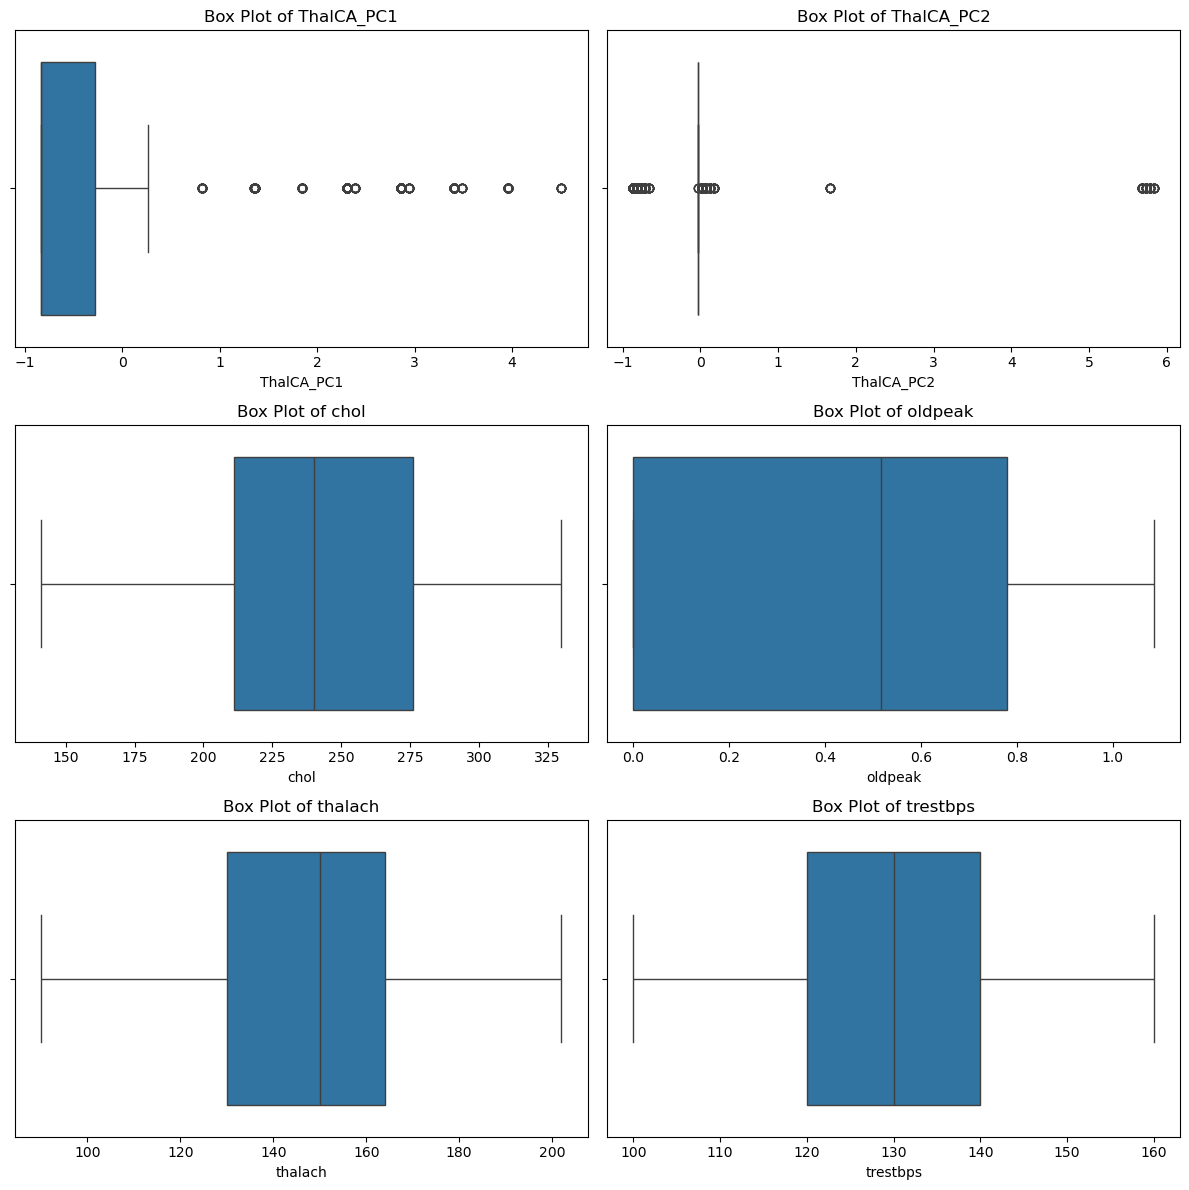

In [104]:
# Boxplots by target (e.g., cholesterol vs target)
if TARGET_COL in df.columns and TARGET_COL in df.select_dtypes(include=[np.number]).columns and df[TARGET_COL].nunique() <= 10:
    if len(continuous_cols) == 0:
        print("No continuous columns to plot.")
    else:
        
        con_to_plot = continuous_cols.copy();
        con_to_plot.remove("age");
        
        n = len(con_to_plot)
        ncols = 2
        nrows = (n + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
        axes = axes.flatten() if n > 1 else [axes]

        for i, col in enumerate(con_to_plot):
            ax = axes[i]
            sns.boxplot(data=df, x=col, ax=ax)
            ax.set_title(f"Box Plot of {col}")
            ax.set_xlabel(col)
            ax.grid(False)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("Target column not suitable for grouping boxplots (missing/not numeric/too many classes).")


### IQR Outlier Summary

In [105]:
# IQR-based outlier detection summary for continuous variables
def iqr_outlier_flags(series: pd.Series, k: float = 1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper), lower, upper

In [106]:
if len(continuous_cols) == 0:
    print("No continuous columns for outlier analysis.")
else:
    rows = []
    for col in continuous_cols:
        flags, lower, upper = iqr_outlier_flags(df[col].dropna())
        outlier_count = int(flags.sum())
        rows.append({
            'column': col,
            'outliers': outlier_count,
            'outliers_pct': round(outlier_count / df[col].dropna().shape[0] * 100, 2),
            'lower_bound': round(lower, 2),
            'upper_bound': round(upper, 2)
        })
    outlier_table = pd.DataFrame(rows).sort_values('outliers', ascending=False)
    display(outlier_table)

,column,outliers,outliers_pct,lower_bound,upper_bound
1,ThalCA_PC2,851,29.15,-0.03,-0.03
0,ThalCA_PC1,659,22.58,-1.66,0.54
2,age,0,0.00,26.00,82.00
3,chol,0,0.00,113.50,373.50
4,oldpeak,0,0.00,-1.17,1.95
5,thalach,0,0.00,79.00,215.00
6,trestbps,0,0.00,90.00,170.00


### Correlation Matrix and Heatmap
- **What this does**: Computes the Pearson correlation among all numeric features and visualizes it as a heatmap. This reveals linear relationships between variables and with the `target` (if numeric/binary).
- **Why it matters**: Strong correlations with `target` highlight promising predictors for the modeling stage (feature selection/importance). High correlations between features indicate potential multicollinearity, guiding regularization (e.g., L1/L2), feature grouping, or dimensionality reduction before models like Logistic Regression.


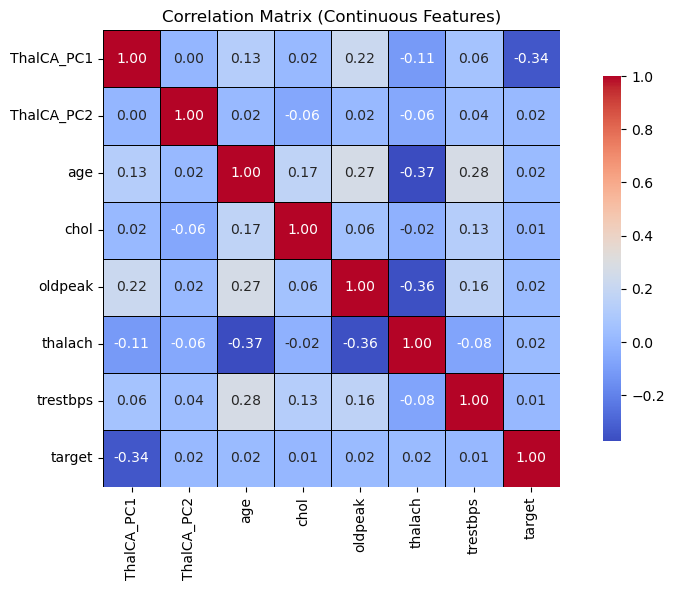

In [107]:
# Correlation matrix and heatmap (continuous features only)
cont_df = df[continuous_cols + [TARGET_COL]]
if len(continuous_cols) <= 1:
    print("Not enough continuous columns for correlation analysis.")
else:
    corr = cont_df.corr(method="pearson")
    plt.figure(figsize=(9, 6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
                cbar_kws={'shrink': .8}, linewidths=0.5, linecolor='black')
    plt.title('Correlation Matrix (Continuous Features)')
    plt.tight_layout()
    plt.show()


### Scatter plots for categorical relationships colored by target
We visualize two pairs:
- Chest pain type vs ST slope, colored by target.
- Chest pain type vs exercise angina, colored by target.

Because these are categorical-coded integers, we apply light jitter and use swarm-like positioning for readability.


In [108]:
def plot_scatter_by_target(df, cols_needed, jitter_strength=0.1):
    if not all(c in df.columns for c in cols_needed):
      print('Missing required columns:', [c for c in cols_needed if c not in df.columns])
    else:
        plot_df = df[cols_needed].dropna().copy()

        # Cast to category for clear ticks and labels (values are codes)
        plot_df[cols_needed[0]] = plot_df[cols_needed[0]].astype(int)
        plot_df[cols_needed[1]] = plot_df[cols_needed[1]].astype(int)

        # Jitter helper for categorical-coded integers
        rng = np.random.default_rng(42)
        jitter_strength = 0.13
        x_jitter = plot_df[cols_needed[0]] + rng.normal(0, jitter_strength, size=len(plot_df))
        y_jitter = plot_df[cols_needed[1]] + rng.normal(0, jitter_strength, size=len(plot_df))

        plt.figure(figsize=(7, 5))
        sns.scatterplot(x=x_jitter, y=y_jitter, hue=plot_df[TARGET_COL].astype(str), palette=['red', 'steelblue'])
        plt.title(f'Scatter plot: {cols_needed[0]} vs {cols_needed[1]} \n(Colored by {TARGET_COL})')
        plt.xlabel(cols_needed[0])
        plt.ylabel(cols_needed[1])

        # Set integer tick locations and labels
        x_levels = sorted(df[cols_needed[0]].dropna().astype(int).unique())
        y_levels = sorted(df[cols_needed[1]].dropna().astype(int).unique())
        plt.xticks(ticks=x_levels, labels=[str(v) for v in x_levels])
        plt.yticks(ticks=y_levels, labels=[str(v) for v in y_levels])
        plt.legend(title='target')
        plt.tight_layout()
        plt.show()

In [109]:
plot_scatter_by_target(df, ['Chest pain type', 'ST slope', TARGET_COL], 0.13)

Missing required columns: ['Chest pain type', 'ST slope']


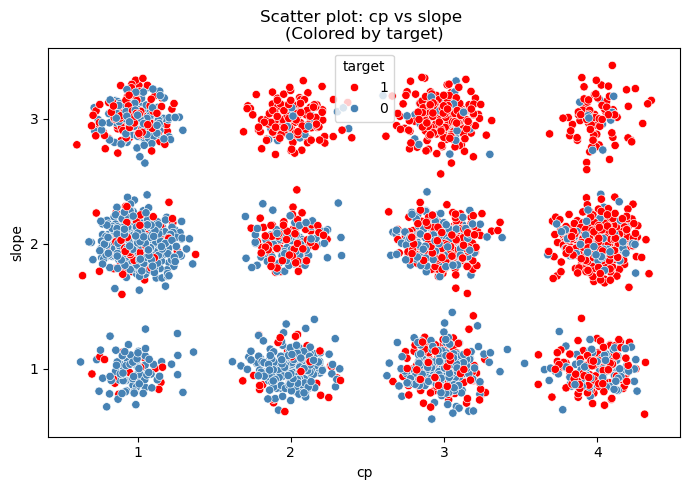

In [110]:
plot_scatter_by_target(df, ['cp', 'slope', TARGET_COL], 0.13)

In [111]:
plot_scatter_by_target(df, ['Chest pain type', 'exercise angina', TARGET_COL], 0.1)

Missing required columns: ['Chest pain type', 'exercise angina']


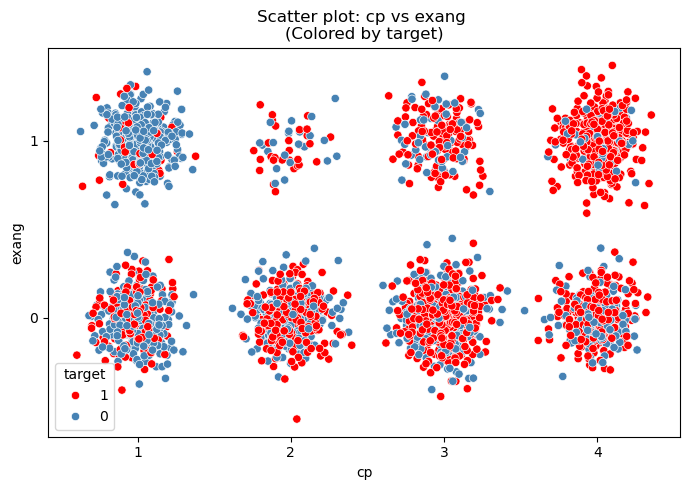

In [112]:
plot_scatter_by_target(df, ['cp', 'exang', TARGET_COL], 0.13)